# Entrenamiento adversario
## EL4106-1 Inteligencia computacional
### **Integrantes:**
### Benjamín Castro 
### Jordan Pérez 
###  **Ayudante:**
### Andrés González
### **Profesor:**
### Pablo Estévez

#### Imports de librerías

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import torchvision
from torch.utils.data import DataLoader

# Red neuronal pre entrenada
from torchvision.models import resnet18, ResNet18_Weights
import torch.backends.cudnn as cudnn

### Dataset Tiny ImageNet

In [ ]:
# Descarga del dataset
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-12-11 16:40:43--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  16.6MB/s    in 68s     

2022-12-11 16:41:51 (3.48 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
!unzip tiny-imagenet-200.zip

In [ ]:
# Normalización [1]
img_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                              std = [0.229, 0.224, 0.225])]) 

train_path = './tiny-imagenet-200/train'
test_path = './tiny-imagenet-200/test'
val_path = './tiny-imagenet-200/val'

# Creación de los dataset
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = img_transform)
val_dataset = torchvision.datasets.ImageFolder(root = val_path, transform = img_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform = img_transform)

# Definición de las clases del dataset
classes = train_dataset.classes

### CIFAR-10

In [2]:
cifar_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=cifar_transform,
)

test_cifar10 = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=cifar_transform)

classes = train_cifar10.classes

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [3]:
# Dataloaders
train_loader = DataLoader(train_cifar10, batch_size = 64, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size = 64, shuffle=False)
test_loader = DataLoader(test_cifar10, batch_size = 64, shuffle=False)

In [4]:
# Dispositivo donde se guardan los datos
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Ataque tipo PGD con momento
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Se crea un ejemplo adversario PGD a partir de X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [6]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [34]:
# Cargar el modelo  
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = model.to(device) # Guardar los pesos del modelo en el dispositivo
model = torch.nn.DataParallel(model)
cudnn.benchmark = True

In [8]:
# Entrenamiento sin factor de corrección en pesos
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [9]:
# Época con entrenamiento adversario (corrección de pesos)
def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

### Entrenamiento adversario

#### Entrenamiento con ataque PGD en test

In [ ]:
# Optimizador SGD
opt = optim.SGD(model.parameters(), lr=1e-1)
tr_err_pgd = []
tr_loss_pgd = []
#val_err_pgd = []
test_err_pgd = []
adv_err_pgd = []
test_loss_pgd = []

# Entrenamiento sin corrección adversaria
# Ataque PGD
for t in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
 #   val_err , val_loss = epoch(val_loader,model)
    test_err, test_loss = epoch(test_loader, model)
    adv_err, adv_loss = epoch_adversarial(test_loader, model, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    tr_err_pgd.append(train_err) # Guardar para graficar
  #  val_err_pgd.append(val_err)
    test_err_pgd.append(test_err)
    adv_err_pgd.append(adv_err)
    tr_loss_pgd.append(train_loss)
    test_loss_pgd.append(test_loss)
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model.state_dict(), "model_cnn_pgd.pt")

0.600340	0.620800	0.917000
0.359080	0.408000	0.945600
0.284080	0.323900	0.948700
0.221300	0.395100	0.946800
0.178480	0.412900	0.949400
0.116280	0.197800	0.937000
0.083240	0.194500	0.929700
0.071040	0.197400	0.920700
0.060660	0.201300	0.910900
0.051020	0.195200	0.908000


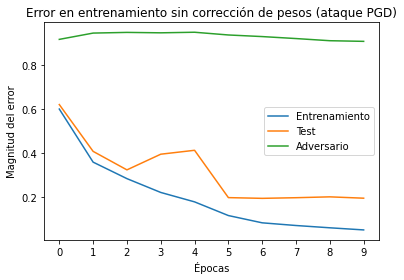

In [ ]:
iter = range(0,10)
plt.xticks(iter)
plt.plot(tr_err_pgd,label='Entrenamiento')
#plt.plot(val_err_pgd,label='Validación')
plt.plot(test_err_pgd,label='Test')
plt.plot(adv_err_pgd,label='Adversario')
plt.legend()
plt.title('Error en entrenamiento sin corrección de pesos (ataque PGD)')
plt.ylabel('Magnitud del error')
plt.xlabel('Épocas')
plt.show()

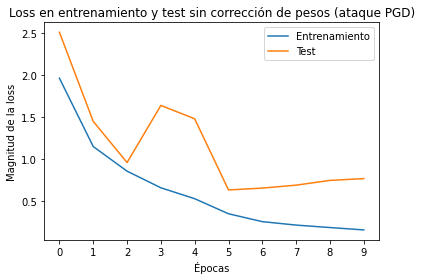

In [ ]:
plt.xticks(iter)
plt.plot(tr_loss_pgd,label='Entrenamiento')
plt.plot(test_loss_pgd,label='Test')
plt.legend()
plt.title('Loss en entrenamiento y test sin corrección de pesos (ataque PGD)')
plt.ylabel('Magnitud de la loss')
plt.xlabel('Épocas')
plt.show()

#### Entrenamiento con ataque FGSM en test

In [ ]:
# Optimizador SGD
opt = optim.SGD(model.parameters(), lr=1e-1)
tr_err_fgsm = []
#val_err_fgsm = []
test_err_fgsm = []
adv_err_fgsm = []
train_loss_fgsm = []
test_loss_fgsm = []

# Entrenamiento sin corrección adversaria
# Ataque FGSM
for t in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    #val_err , val_loss = epoch(val_loader,model)
    test_err, test_loss = epoch(test_loader, model)
    adv_err, adv_loss = epoch_adversarial(test_loader, model, fgsm)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    tr_err_fgsm.append(train_err) # Guardar para graficar
    #val_err_fgsm.append(val_err)
    test_err_fgsm.append(test_err)
    adv_err_fgsm.append(adv_err)
    train_loss_fgsm.append(train_loss)
    test_loss_fgsm.append(test_loss)
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model.state_dict(), "model_fgsm_cnn.pt")

0.132380	0.340600	0.675600
0.105000	0.239400	0.634800
0.086960	0.224200	0.641200
0.071520	0.250600	0.644900
0.057560	0.269900	0.636600
0.027840	0.189400	0.552900
0.010260	0.186400	0.539500
0.005660	0.186400	0.528600
0.003680	0.185600	0.523500
0.003000	0.184400	0.520500


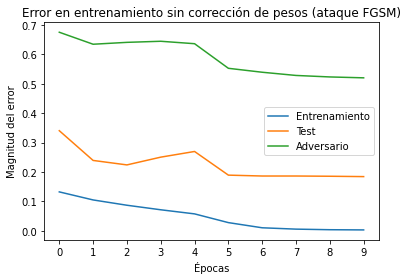

In [ ]:
iter = range(0,10)
plt.xticks(iter)
plt.plot(tr_err_fgsm,label='Entrenamiento')
#plt.plot(val_err_fgsm,label='Validación')
plt.plot(test_err_fgsm,label='Test')
plt.plot(adv_err_fgsm,label='Adversario')
plt.legend()
plt.title('Error en entrenamiento sin corrección de pesos (ataque FGSM)')
plt.ylabel('Magnitud del error')
plt.xlabel('Épocas')
plt.show()

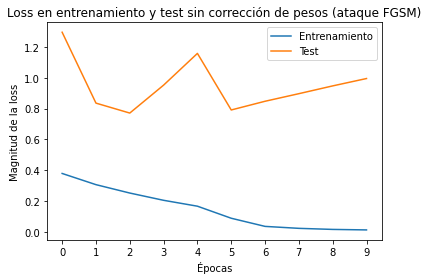

In [ ]:
iter = range(0,10)
plt.xticks(iter)
plt.plot(train_loss_fgsm,label='Entrenamiento')
plt.plot(test_loss_fgsm,label='Test')
plt.legend()
plt.title('Loss en entrenamiento y test sin corrección de pesos (ataque FGSM)')
plt.ylabel('Magnitud de la loss')
plt.xlabel('Épocas')
plt.show()

#### Entrenamiento con ataque FGSM en entrenamiento

In [ ]:
opt = optim.SGD(model.parameters(), lr=1e-1)

tr_err_adv_fgsm = []
#val_err_adv_fgsm = []
test_err_adv_fgsm = []
adv_err_adv_fgsm = []
tr_loss_adv_fgsm = []
test_loss_adv_fgsm = []

for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model, fgsm, opt)
    #val_err , val_loss = epoch(val_loader,model)
    test_err, test_loss = epoch(test_loader, model)
    adv_err, adv_loss = epoch_adversarial(test_loader, model, fgsm)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    tr_err_adv_fgsm.append(train_err) # Guardar para graficar
    #val_err_adv_fgsm.append(val_err)
    test_err_adv_fgsm.append(test_err)
    adv_err_adv_fgsm.append(adv_err)
    tr_loss_adv_fgsm.append(train_loss)
    test_loss_adv_fgsm.append(test_loss)
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model.state_dict(), "model_adv_train_fgsm.pt")


0.666640	0.518300	0.696100
0.610680	0.479400	0.669000
0.583560	0.644000	0.754000
0.562080	0.507700	0.665400
0.542980	0.414000	0.638200
0.501480	0.291500	0.577300
0.493300	0.283600	0.579200
0.487420	0.283300	0.581300
0.487100	0.281500	0.586500
0.481220	0.281300	0.579400


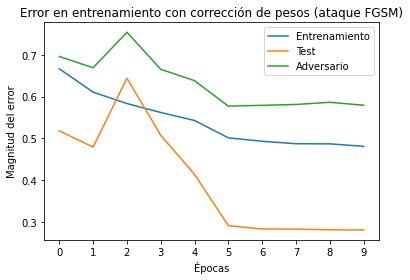

In [ ]:
iter = range(0,10)
plt.xticks(iter)
plt.plot(tr_err_adv_fgsm,label='Entrenamiento')
#plt.plot(val_err_adv_fgsm,label='Validación')
plt.plot(test_err_adv_fgsm,label='Test')
plt.plot(adv_err_adv_fgsm,label='Adversario')
plt.legend()
plt.title('Error en entrenamiento con corrección de pesos (ataque FGSM)')
plt.ylabel('Magnitud del error')
plt.xlabel('Épocas')
plt.show()

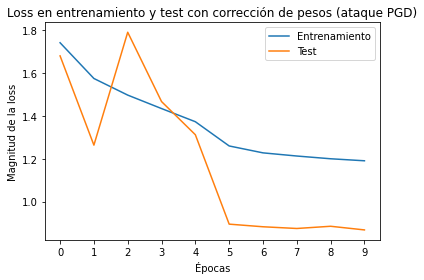

In [ ]:
plt.xticks(iter)
plt.plot(tr_loss_adv_fgsm,label='Entrenamiento')
plt.plot(test_loss_adv_fgsm,label='Test')
plt.legend()
plt.title('Loss en entrenamiento y test con corrección de pesos (ataque PGD)')
plt.ylabel('Magnitud de la loss')
plt.xlabel('Épocas')
plt.show()

#### Entrenamiento con ataque PGD en entrenamiento

In [ ]:
opt = optim.SGD(model.parameters(), lr=1e-1)

tr_err_adv_pgd = []
#val_err_adv_pgd = []
test_err_adv_pgd = []
adv_err_adv_pgd = []
tr_loss_adv_pgd = []
test_loss_adv_pgd = []

for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model, pgd_linf, opt)
    #val_err , val_loss = epoch(val_loader,model)
    test_err, test_loss = epoch(test_loader, model)
    adv_err, adv_loss = epoch_adversarial(test_loader, model, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    tr_err_adv_pgd.append(train_err) # Guardar para graficar
    #val_err_adv_pgd.append(val_err)
    test_err_adv_pgd.append(test_err)
    adv_err_adv_pgd.append(adv_err)
    tr_loss_adv_pgd.append(train_loss)
    test_loss_adv_pgd.append(test_loss)
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model.state_dict(), "model_adv_train_pgd.pt")


0.585220	0.563500	0.733300
0.572040	0.389000	0.664500
0.558860	0.854900	0.863700
0.590740	0.438700	0.669000
0.550980	0.412000	0.664600
0.506040	0.295500	0.606900
0.497640	0.299100	0.608000
0.495520	0.290600	0.607900
0.491200	0.286700	0.609600
0.486500	0.290800	0.609300


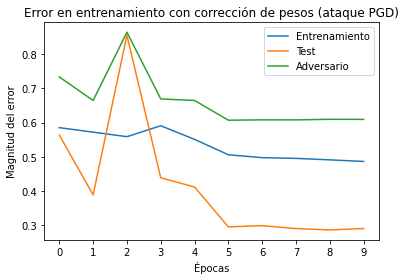

In [ ]:
iter = range(0,10)
plt.xticks(iter)
plt.plot(tr_err_adv_pgd,label='Entrenamiento')
#plt.plot(val_err_adv_pgd,label='Validación')
plt.plot(test_err_adv_pgd,label='Test')
plt.plot(adv_err_adv_pgd,label='Adversario')
plt.legend()
plt.title('Error en entrenamiento con corrección de pesos (ataque PGD)')
plt.ylabel('Magnitud del error')
plt.xlabel('Épocas')
plt.show()

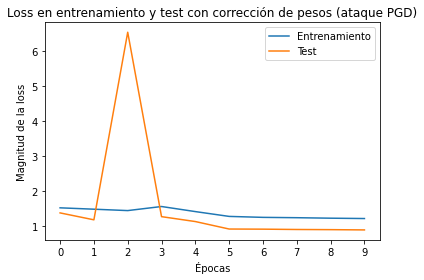

In [ ]:
plt.xticks(iter)
plt.plot(tr_loss_adv_pgd,label='Entrenamiento')
plt.plot(test_loss_adv_pgd,label='Test')
plt.legend()
plt.title('Loss en entrenamiento y test con corrección de pesos (ataque PGD)')
plt.ylabel('Magnitud de la loss')
plt.xlabel('Épocas')
plt.show()

### Referencias
#### [1] M. Pintor et. al (2019), *ImageNet-Patch: A Dataset for Benchmarking Machine Learning Robustness against Adversarial Patches*,  arxiv [En línea] https://arxiv.org/pdf/2203.04412.pdf